In [1]:
import sys
sys.path.append("/tmp/pycharm_project")

from scheme.plotting import _draw_network
from scheme.networks import duplication_divergence_graph
from scheme.util import StatefulPRNGKey

# Random Seed
seed = 1234567890
# Number of genes to generate
n_genes = 250
# The percentage of edges to prune after generation
sparsity_factor = 0.25

rng_key = StatefulPRNGKey(seed)

/opt/conda/envs/scheme_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Base Topology
Topology of molecular interaction networks: https://link.springer.com/article/10.1186/1752-0509-7-90
- Gene networks are multi-scale
- Barabasi-Albert or Duplication-Divergence graphs are scale-free and work okay
-

On the evolution of scale-free topologies with a gene regulatory network model: https://www.sciencedirect.com/science/article/pii/S0303264709001087?casa_token=pbVT3sbkH1sAAAAA:qydQn7nE5-7tJlVZem4ZNQJUm2qzNlyQlGBuVlgbgJL7wH1B2y4caxSLiprCWCkcfbnEP2ig8g
- Duplication-divergence graphs are useful to make a scale-free network that are realistic

Scale-free networks in cell biology: https://journals.biologists.com/jcs/article/118/21/4947/28519/Scale-free-networks-in-cell-biology
-

Artificial Gene Regulatory
Networks—A Review: https://ieeexplore.ieee.org/abstract/document/8662826

In [4]:
G = duplication_divergence_graph(250, 0.4, .1, rng_key)

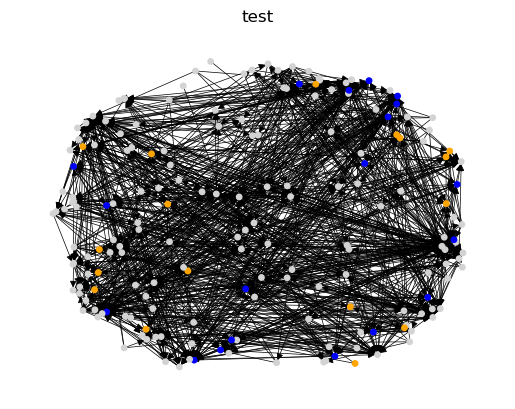

<Figure size 640x480 with 0 Axes>

In [5]:
_draw_network(G, "test")

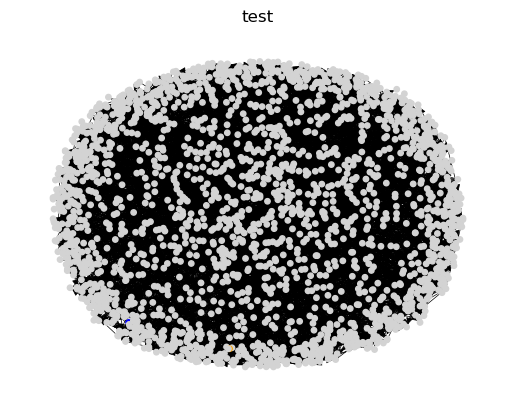

<Figure size 640x480 with 0 Axes>

In [6]:
G = duplication_divergence_graph(2500, 0.75, .01, rng_key)
_draw_network(G, "test")